In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

タイタニック号のデータをダウンロードする

In [2]:
data = pd.read_csv('../input/train.csv')
data['Pclass'] = data['Pclass'].map(str) # pclassの型を文字列型に変換

データの最初の数行を表示

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


データの統計を表示

In [4]:
data.describe()

,PassengerId,Survived,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,80.000000,8.000000,6.000000,512.329200


欠損値を含む行を削除

In [5]:
data[['Age']].dropna()
data[['Cabin']].dropna()

,Cabin
1,C85
3,C123
6,E46
10,G6
11,C103
21,D56
23,A6
27,C23 C25 C27
31,B78
52,D33


年齢（age）と料金（fare）の相関を見る

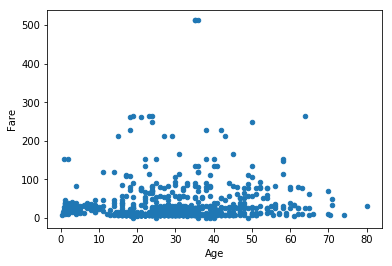

In [6]:
df = data[['Age','Fare']].dropna()
df.plot(kind='scatter', x='Age', y='Fare')

料金と社会的地位の相関を見る

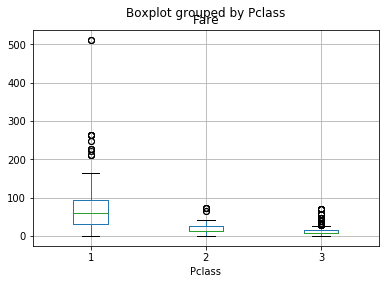

In [7]:
df = data[['Fare','Pclass']].dropna()
df.boxplot(column='Fare', by='Pclass')

社会的地位が高い(1)の人ほど、料金が高い

性別による、生き残りの相関を見る

In [8]:
df = data[['Sex','Survived']].dropna()
pd.crosstab(df.Sex, df.Survived)

Survived,0,1
Sex,,
female,81,233
male,468,109


女性は生き残った人が多く、男性は死亡した人が多い。

社会的地位による、生き残りの相関を見る

In [9]:
df = data[['Pclass','Survived']].dropna()
pd.crosstab(df.Pclass, df.Survived)

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


数値データの相関をプロット

In [10]:
import seaborn as sns

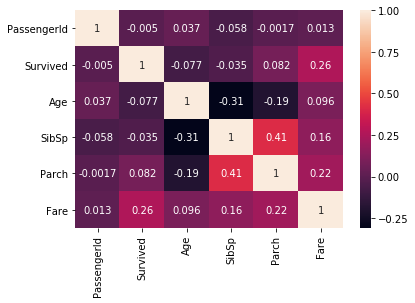

In [11]:
sns.heatmap(data.corr(), annot=True)

生き残ったかどうかに対しての相関は、Fare(運賃)が高い

地位が高い(値が小さい)ほど、生き残りの確率が高い

「社会的地位」「性別」「運賃」の3つの特徴を用いて、生存確率を予測するモ
デルを構築する

In [12]:
import lightgbm as lgb
from PIL import Image
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

欠損値を含む行を削除して、分析に使用する列のみを含むDataFrameを用意する。
ここでは、特徴変数 X とラベル y を個別にDataFrameとして作成している。

In [13]:
tmp = data[['Pclass', 'Sex', 'Fare','Survived']].dropna()
X = tmp[['Pclass', 'Sex','Fare']]
y = tmp['Survived']
X.head()

,Pclass,Sex,Fare
0,3,male,7.2500
1,1,female,71.2833
2,3,female,7.9250
3,1,female,53.1000
4,3,male,8.0500


社会的地位と性別を数値表現にする

In [14]:
from sklearn import preprocessing

In [15]:
le = preprocessing.LabelEncoder()
for column in ['Sex','Pclass']:
    le.fit(X[column])
    X[column] = le.transform(X[column])

C:\Users\MaMto\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


scikit-learnによる、回帰分析

データセットをトレーニングセットとテストデータに分割し、トレーニングセットを使って学習

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
model = lgb.LGBMClassifier(n_estimators=500)
X_train.dtypes

Pclass      int64
Sex         int64
Fare      float64
dtype: object

In [17]:
model.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_val, y_val)],  eval_metric= 'auc', early_stopping_rounds= 20)

[1]	training's binary_logloss: 0.619945	training's auc: 0.873593	valid_1's binary_logloss: 0.64058	valid_1's auc: 0.819979
Training until validation scores don't improve for 20 rounds.
[2]	training's binary_logloss: 0.585713	training's auc: 0.874198	valid_1's binary_logloss: 0.610205	valid_1's auc: 0.829995
[3]	training's binary_logloss: 0.557041	training's auc: 0.877525	valid_1's binary_logloss: 0.583738	valid_1's auc: 0.838007
[4]	training's binary_logloss: 0.533606	training's auc: 0.877676	valid_1's binary_logloss: 0.562411	valid_1's auc: 0.847054
[5]	training's binary_logloss: 0.513975	training's auc: 0.878406	valid_1's binary_logloss: 0.546051	valid_1's auc: 0.844146
[6]	training's binary_logloss: 0.49749	training's auc: 0.879589	valid_1's binary_logloss: 0.532146	valid_1's auc: 0.845955
[7]	training's binary_logloss: 0.483178	training's auc: 0.879967	valid_1's binary_logloss: 0.519147	valid_1's auc: 0.846472
[8]	training's binary_logloss: 0.471023	training's auc: 0.880235	valid_1

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=500, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

訓練データをモデルに与えて予測する

In [18]:
y_pred = model.predict_proba(X_val)
y_pred_max = np.argmax(y_pred, axis=1)  # 最尤と判断したクラスの値にする
y_pred_max

array([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1], dtype=int64)

学習結果を用いて、トレーニングセットとテストデータに対する正解率を計算する

In [19]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
print('Accuracy on Training Set:',accuracy_score(y_train, y_train_pred))
print ('Accuracy on Validation Set: ',accuracy_score(y_val, y_val_pred))

Accuracy on Training Set: 0.848314606741573
Accuracy on Validation Set:  0.8100558659217877


C:\Users\MaMto\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\MaMto\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


クロスバリデーションを実施

In [20]:
scores = cross_val_score(model, X, y, cv=5)
print ('Scores:', scores)
print ('Mean Score:',scores.mean(),'±',scores.std())

C:\Users\MaMto\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\MaMto\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\MaMto\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\MaMto\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

Scores: [0.75977654 0.7877095  0.84831461 0.82022472 0.81355932]
Mean Score: 0.8059169362792297 ± 0.03007034591278395


C:\Users\MaMto\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Kaggleのテストデータを読み込み

In [21]:
test_data = pd.read_csv('../input/test.csv')
test_data['Pclass'] = test_data['Pclass'].map(str) # pclassの型を文字列型に変換
test_data_x = test_data[['Pclass', 'Sex','Fare']]

社会的地位と性別を数値表現にする

In [22]:
le = preprocessing.LabelEncoder()
for column in ['Sex','Pclass']:
    le.fit(test_data_x[column])
    test_data_x[column] = le.transform(test_data_x[column])

C:\Users\MaMto\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
test_pred = model.predict_proba(test_data_x)
test_pred_max = np.argmax(test_pred, axis=1)  # 最尤と判断したクラスの値にする
test_pred_max

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

kaggleに提出するデータを作成

In [24]:
submission = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived':np.array(test_pred_max)})
submission.to_csv('submission.csv', index=False)

提出したスコアは、0.79904だった。
単純にロジスティック回帰を使ったときより少し良くなった。